**The Final Analysis Notebook For The Convoy Data Ensemble Model**

In [47]:
#Imports
#Imports
import numpy as np
import pandas as pd
import sys, os, random
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (roc_auc_score, recall_score, precision_score, f1_score, matthews_corrcoef, \
                             balanced_accuracy_score, confusion_matrix,classification_report )
from pathlib import Path
from datetime import datetime
import json
import joblib

#Warning Supression
import warnings
warnings.filterwarnings("ignore", module="skopt") #Ignore scikit-optimize warning print lines
from scipy.linalg import LinAlgWarning
warnings.filterwarnings("ignore", category=LinAlgWarning) #For QDA
warnings.filterwarnings("ignore", category=UserWarning) #For LightBoost

#Class Import
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../.."))) #Allow for imports from src
from src.models import ML_Class_2
importlib.reload(ML_Class_2) #Ensures file is uptodate!
from src.models.ML_Class_2 import Model_Tester_V2

#Utils Import
from src.models.model_artifacts import (get_artifact_dir, load_model, load_models, save_model, save_models,)
ARTIFACT_DIR = get_artifact_dir("algorithm_test_3")
from src.models import model_specs
importlib.reload(model_specs) #Ensures file is uptodate!
from src.models.model_specs import MODEL_SPECS
from src.models.perf_utils import track_performance

#Set Seed
os.environ["PYTHONHASHSEED"] = "1945"
random.seed(1945)
np.random.seed(1945)

In [48]:
#Complied data of convoys
#Routes examined are HX, SC, OB, ON, ONS
df = pd.read_csv('/Users/matthewplambeck/Desktop/Convoy Predictor/data/processed/Complete_Convoy_Data.csv')
df = df.drop(columns=['Unnamed: 0'])
# df.shape #Test
#Drop unecessary/redundent features
df = df.drop(columns=['Convoy Number', 'Number of Ships Sunk', 'Depart_Date', 'Arrival/Dispersal Date', 'Number of Escorts Sunk', \
                         'Number of Stragglers Sunk', 'Total Tons of Ships Sunk', 'Escort Sink Percentage', 'Straggler Sink Percentage'])
df.reset_index(drop=True).head(3)
#Convert Overall Sink Percentage to binary 1( High)
df['Risk'] = (df['Overall Sink Percentage'] > 0).astype(int) 
#Risk is binary based off whether a ship was sunk while in a convoy:  (0 = No Ships Sunk, 1 = At Least One Ship Sunk)
X = np.array(df.drop(columns=['Overall Sink Percentage', 'Risk'])) #Remove Overall Sink Percentage as it leaks data
y = df['Risk'].values #Prediction value

In [58]:
#Feature Names for later feature analysis:
X_df = df.drop(columns=['Overall Sink Percentage', 'Risk'])
X = X_df.values
y = df['Risk'].values
feature_names = list(X_df.columns)


In [50]:
#Model Tester Utility Function

#Shared split for all models/ensembles
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.8,
    random_state=1945,
    stratify=y,)

def prepare_tester(model_key, *, scaler=None, cv_folds=None):
    spec = MODEL_SPECS[model_key]
    tester = Model_Tester_V2(
        model=spec["estimator"],
        scaler=scaler,
        parameter_grid=spec["grid_large"],
        cv_folds=cv_folds or spec.get("cv_folds", 5),
        feature_names=feature_names,
        model_config=spec["config"],)
    tester.X_train, tester.X_test = X_train, X_test
    tester.y_train, tester.y_test = y_train, y_test
    if callable(tester.parameter_grid):
        tester.parameter_grid = tester.parameter_grid(tester.y_train)
    return tester

In [51]:
# --- Voting Ensemble Evaluator ---

def evaluate_voting_ensemble(
    estimators_dict,
    X_train,
    X_test,
    y_train,
    y_test,
    threshold=0.5,
    voting="soft",
    ensemble_name=None,
    pos_label=1,
    verbose=True,
    weights=None,
):
    estimators_list = [(name, est) for name, est in estimators_dict.items()]
    if ensemble_name is None:
        ensemble_name = "VotingEnsemble_" + "_".join(sorted(estimators_dict.keys()))

    voter = VotingClassifier(
        estimators=estimators_list,
        voting=voting,
        weights=weights,
        n_jobs=-1,
    )
    voter.fit(X_train, y_train)

    if voting == "soft":
        proba_pos = voter.predict_proba(X_test)[:, 1]
        y_pred = (proba_pos >= threshold).astype(int)
    else:
        y_pred = voter.predict(X_test)
        proba_pos = None

    roc_auc = roc_auc_score(y_test, proba_pos) if proba_pos is not None else np.nan
    acc = np.mean(y_pred == y_test)
    recall_1 = recall_score(y_test, y_pred, pos_label=pos_label)
    precision_1 = precision_score(y_test, y_pred, pos_label=pos_label, zero_division=0)
    f1_1 = f1_score(y_test, y_pred, pos_label=pos_label, zero_division=0)
    mcc = matthews_corrcoef(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=["True 0", "True 1"], columns=["Pred 0", "Pred 1"])
    cls_report = classification_report(y_test, y_pred, digits=3, zero_division=0)

    if verbose:
        print(f"Ensemble: {ensemble_name}")
        print(f"Voting: {voting}")
        if voting == "soft":
            print(f"Threshold: {threshold:.2f}")
        if weights is not None:
            print(f"Weights: {weights}")
        print(f"ROC AUC: {roc_auc:.3f}")
        print(f"Accuracy: {acc:.3f}")
        print(f"Recall (class {pos_label}): {recall_1:.3f}")
        print(f"Precision (class {pos_label}): {precision_1:.3f}")
        print(f"F1 (class {pos_label}): {f1_1:.3f}")
        print(f"MCC: {mcc:.3f}")
        print(f"Balanced Accuracy: {bal_acc:.3f}")
        print("Confusion Matrix:")
        print(cm_df)
        print("Classification Report (digits=3):")
        print(cls_report)

    results_df = pd.DataFrame([
        {
            "Model": ensemble_name,
            "Threshold": threshold if voting == "soft" else np.nan,
            "Acc": acc,
            "ROC_AUC": roc_auc,
            "MCC": mcc,
            "Bal_Acc": bal_acc,
            "Recall_1": recall_1,
            "Precision_1": precision_1,
            "F1_1": f1_1,
        }
    ])

    return results_df, voter, cm_df, cls_report


# --- Load ALL MODELS USED IN FINAL ENSEMBLE MODEL --- 


# --- DecisionTreeClassifier ---
dt = prepare_tester("dt")
load_model("dt", directory=ARTIFACT_DIR, assign_to=dt)
# dt_results = dt.evaluate(show_plots=False)

# --- RandomForestClassifier ---
rf = prepare_tester("rf")
load_model("rf", directory=ARTIFACT_DIR, assign_to=rf)
# fr_results = rf.evaluate(show_plots=False)

# --- ExtraTreesClassifier ---
et = prepare_tester("et")
load_model("et", directory=ARTIFACT_DIR, assign_to=et)
# et_results = et.evaluate(show_plots=False)


# --- AdaBoostClassifier ---
ada = prepare_tester("ada")
load_model("ada", directory=ARTIFACT_DIR, assign_to=ada)
# ada_results = ada.evaluate(show_plots=False)

# --- QuadraticDiscriminantAnalysis ---
qda = prepare_tester("qda")
load_model("qda", directory=ARTIFACT_DIR, assign_to=qda)
# qda_results = qda.evaluate(show_plots=False)



,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,priors,None
,reg_param,0.0
,store_covariance,False
,tol,0.001


In [52]:
# --- Five Model Ensemble ---

#Models
dt_ensemble = dt.best_model
rf_ensemble = rf.best_model
et_ensemble = et.best_model
ada_ensemble = ada.best_model
qda_ensemble = qda.best_model

def run_five_model_calsoft_t025(
    X_train, X_test, y_train, y_test,
    qda_ensemble, ada_ensemble, dt_ensemble, rf_ensemble, et_ensemble,
):
    five_model_ensemble = {
        "qda": qda_ensemble,
        "ada": ada_ensemble,
        "dt": dt_ensemble,
        "rf": rf_ensemble,
        "et": et_ensemble,
    }

    calibrated_five = {}
    for name, est in five_model_ensemble.items():
        cal = CalibratedClassifierCV(est, method="sigmoid", cv=3)
        cal.fit(X_train, y_train)
        calibrated_five[name] = cal

    return evaluate_voting_ensemble(
        calibrated_five,
        X_train,
        X_test,
        y_train,
        y_test,
        threshold=0.25,
        voting="soft",
        ensemble_name="FiveModel_CalSoft_t0.25",)


res_calsoft_025, voter_calsoft_025, cm_calsoft_025, rep_calsoft_025 = run_five_model_calsoft_t025(
    X_train,
    X_test,
    y_train,
    y_test,
    qda_ensemble,
    ada_ensemble,
    dt_ensemble,
    rf_ensemble,
    et_ensemble,)

res_calsoft_025

Ensemble: FiveModel_CalSoft_t0.25
Voting: soft
Threshold: 0.25
ROC AUC: 0.821
Accuracy: 0.830
Recall (class 1): 0.680
Precision (class 1): 0.586
F1 (class 1): 0.630
MCC: 0.522
Balanced Accuracy: 0.775
Confusion Matrix:
        Pred 0  Pred 1
True 0     161      24
True 1      16      34
Classification Report (digits=3):
              precision    recall  f1-score   support

           0      0.910     0.870     0.890       185
           1      0.586     0.680     0.630        50

    accuracy                          0.830       235
   macro avg      0.748     0.775     0.760       235
weighted avg      0.841     0.830     0.834       235



,Model,Threshold,Acc,ROC_AUC,MCC,Bal_Acc,Recall_1,Precision_1,F1_1
0,FiveModel_CalSoft_t0.25,0.25,0.829787,0.820865,0.522332,0.775135,0.68,0.586207,0.62963


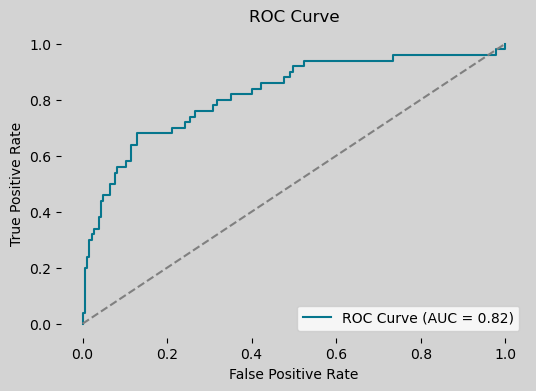

In [53]:
# ROC Curve Plot (FiveModel_CalSoft_t0.25)
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, ROC_AUC, model_name):
    """
    ROC Curve Plot
    """
    plt.figure(figsize=(6,4), facecolor='lightgrey')
    plt.plot(fpr, tpr, color='#06768d', label=f'ROC Curve (AUC = {ROC_AUC:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    ax = plt.gca()
    ax.set_facecolor('lightgrey')
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.savefig(f"/Users/matthewplambeck/Desktop/Convoy Predictor/Plots/{model_name}_PR_Curve.png")
    plt.show()

model_name = "FiveModel_CalSoft_t0.25"
y_proba = voter_calsoft_025.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
ROC_AUC = roc_auc_score(y_test, y_proba)
plot_roc_curve(fpr, tpr, ROC_AUC, model_name=model_name)


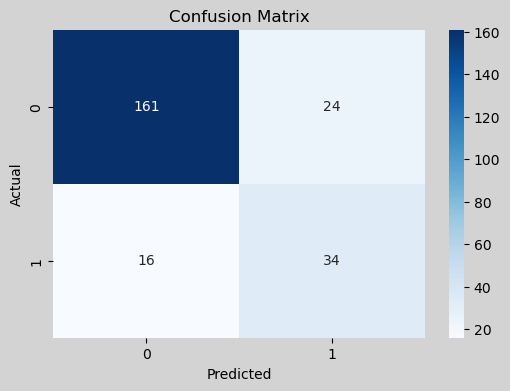

In [54]:
# Confusion Matrix Plot (FiveModel_CalSoft_t0.25)

def plot_confusion_matrix(cm, model_name, class_labels=None):
    """
    Plot Confusion Matrix
    """
    if class_labels is None:
        labels_to_use = [str(i) for i in range(cm.shape[0])]
    else:
        labels_to_use = [str(label) for label in class_labels]

    plt.figure(figsize=(6,4), facecolor='lightgrey')
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_to_use, \
                yticklabels=labels_to_use)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig(f"/Users/matthewplambeck/Desktop/Convoy Predictor/Plots/{model_name}_CM.png")
    plt.show()

model_name = "FiveModel_CalSoft_t0.25"
y_proba = voter_calsoft_025.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.25).astype(int)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, model_name=model_name, class_labels=[0, 1])


In [ ]:
# Permutation Importance (FiveModel_CalSoft_t0.25)
from sklearn.inspection import permutation_importance

model_name = "FiveModel_CalSoft_t0.25"
perm = permutation_importance(
    voter_calsoft_025,
    X_test,
    y_test,
    n_repeats=30,
    random_state=1945,
    scoring="recall",
)

perm_df = pd.DataFrame({
    "Feature": feature_names[:len(perm.importances_mean)],
    "Importance": perm.importances_mean,
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,4), facecolor='lightgrey')
ax = sns.barplot(x="Importance", y="Feature", data=perm_df, palette='crest_r')
plt.title('Permutation Importance')
ax.set_facecolor('lightgrey')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.savefig(f"/Users/matthewplambeck/Desktop/Convoy Predictor/Plots/{model_name}_Permutation_Importance.png")
plt.show()
perm_df


/var/folders/9n/my6phbv923z13rq9j99h3qz40000gn/T/ipykernel_85623/3346187876.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Importance", y="Feature", data=agg_df, palette='crest_r')


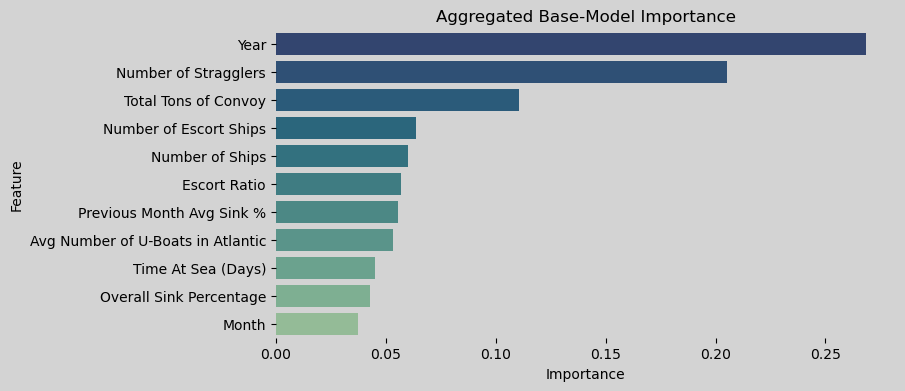

In [56]:
# Aggregated Base-Model Importance (FiveModel_CalSoft_t0.25)

def _extract_importance_from_estimator(est):
    if hasattr(est, "named_steps") and "model" in est.named_steps:
        est = est.named_steps["model"]
    if hasattr(est, "feature_importances_"):
        return np.asarray(est.feature_importances_)
    if hasattr(est, "coef_"):
        coef = np.asarray(est.coef_)
        if coef.ndim == 1:
            return np.abs(coef)
        return np.mean(np.abs(coef), axis=0)
    return None

def _unwrap_calibrated(est):
    if hasattr(est, "calibrated_classifiers_") and len(est.calibrated_classifiers_) > 0:
        imps = []
        for cc in est.calibrated_classifiers_:
            base = getattr(cc, "estimator", None)
            if base is None:
                continue
            imp = _extract_importance_from_estimator(base)
            if imp is not None:
                imps.append(np.asarray(imp))
        if imps:
            min_len = min(len(i) for i in imps)
            return np.mean([i[:min_len] for i in imps], axis=0)
    return _extract_importance_from_estimator(est)

model_name = "FiveModel_CalSoft_t0.25"
base_imps = []
for est in voter_calsoft_025.estimators_:
    imp = _unwrap_calibrated(est)
    if imp is not None:
        base_imps.append(np.asarray(imp))

if not base_imps:
    print('No base estimators exposed feature importances/coefficients.')
else:
    min_len = min(len(i) for i in base_imps)
    agg_imp = np.mean([i[:min_len] for i in base_imps], axis=0)
    agg_df = pd.DataFrame({
        "Feature": feature_names[:len(agg_imp)],
        "Importance": agg_imp,
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(8,4), facecolor='lightgrey')
    ax = sns.barplot(x="Importance", y="Feature", data=agg_df, palette='crest_r')
    plt.title('Aggregated Base-Model Importance')
    ax.set_facecolor('lightgrey')
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.savefig(f"/Users/matthewplambeck/Desktop/Convoy Predictor/Plots/{model_name}_Aggregated_Importance.png")
    plt.show()
    agg_df


/var/folders/9n/my6phbv923z13rq9j99h3qz40000gn/T/ipykernel_85623/1053774122.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Importance", y="Feature", data=shap_df, palette='crest_r')


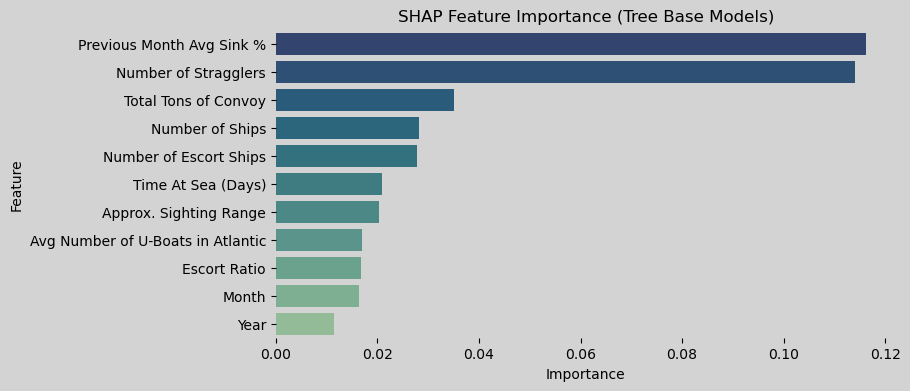

In [61]:
# SHAP Importance (Tree Models in FiveModel_CalSoft_t0.25)

model_name = "FiveModel_CalSoft_t0.25"
try:
    import shap
except ImportError:
    print("SHAP is not installed. Install with: pip install shap")
else:
    shap_imps = []

    def _unwrap_for_shap(est):
        if hasattr(est, "calibrated_classifiers_") and len(est.calibrated_classifiers_) > 0:
            return getattr(est.calibrated_classifiers_[0], "estimator", est)
        return est

    n_features = X_test.shape[1]
    active_feature_names = feature_names[:n_features]

    for est in voter_calsoft_025.estimators_:
        base = _unwrap_for_shap(est)
        if hasattr(base, "named_steps") and "model" in base.named_steps:
            base = base.named_steps["model"]

        if not hasattr(base, "predict"):
            continue

        try:
            explainer = shap.TreeExplainer(base)
            shap_vals = explainer.shap_values(X_test)

            if isinstance(shap_vals, list):
                vals = np.asarray(shap_vals[-1])
            else:
                vals = np.asarray(shap_vals)

            mean_abs = np.mean(np.abs(vals), axis=0)
            mean_abs = np.asarray(mean_abs).squeeze()

            if mean_abs.ndim > 1:
                if mean_abs.shape[0] == n_features:
                    mean_abs = np.mean(mean_abs, axis=tuple(range(1, mean_abs.ndim)))
                elif mean_abs.shape[-1] == n_features:
                    mean_abs = np.mean(mean_abs, axis=tuple(range(0, mean_abs.ndim - 1)))
                else:
                    mean_abs = np.ravel(mean_abs)[:n_features]

            mean_abs = np.ravel(mean_abs)
            if mean_abs.size >= n_features:
                shap_imps.append(mean_abs[:n_features])
        except Exception:
            continue

    if not shap_imps:
        print('No compatible tree estimators available for SHAP in this ensemble.')
    else:
        min_len = min(len(i) for i in shap_imps)
        shap_mean = np.mean([i[:min_len] for i in shap_imps], axis=0)
        shap_mean = np.ravel(shap_mean)

        shap_df = pd.DataFrame({
            "Feature": active_feature_names[:len(shap_mean)],
            "Importance": shap_mean,
        }).sort_values(by="Importance", ascending=False)

        plt.figure(figsize=(8,4), facecolor='lightgrey')
        ax = sns.barplot(x="Importance", y="Feature", data=shap_df, palette='crest_r')
        plt.title('SHAP Feature Importance (Tree Base Models)')
        ax.set_facecolor('lightgrey')
        for spine in plt.gca().spines.values():
            spine.set_visible(False)
        plt.savefig(f"/Users/matthewplambeck/Desktop/Convoy Predictor/Plots/{model_name}_SHAP_Importance.png")
        plt.show()
        shap_df


In [67]:
# Keep metadata BEFORE dropping columns for X
raw_df = pd.read_csv('/Users/matthewplambeck/Desktop/Convoy Predictor/data/processed/Complete_Convoy_Data.csv')
raw_df = raw_df.drop(columns=['Unnamed: 0']).reset_index(drop=True)

# Match the model-training preprocessing
model_df = raw_df.drop(columns=[
    'Convoy Number',
    'Number of Ships Sunk',
    'Depart_Date',
    'Arrival/Dispersal Date',
    'Number of Escorts Sunk',
    'Number of Stragglers Sunk',
    'Total Tons of Ships Sunk',
    'Escort Sink Percentage',
    'Straggler Sink Percentage',
])
model_df['Risk'] = (model_df['Overall Sink Percentage'] > 0).astype(int)
X_df = model_df.drop(columns=['Overall Sink Percentage', 'Risk'])
y_arr = model_df['Risk'].values

# Split with row indices so we can map back to full original rows
row_idx = np.arange(len(X_df))
_, X_test_meta, _, y_test_meta, _, idx_test = train_test_split(
    X_df,
    y_arr,
    row_idx,
    train_size=0.8,
    random_state=1945,
    stratify=y_arr,
)

# Ensemble predictions on the same split definition
y_proba = voter_calsoft_025.predict_proba(X_test_meta)[:, 1]
y_pred = (y_proba >= 0.25).astype(int)

# Full original dataframe with test predictions attached
all_rows_scored = raw_df.copy()
all_rows_scored['Actual'] = np.nan
all_rows_scored['Predicted'] = np.nan
all_rows_scored['Pred_Prob'] = np.nan
all_rows_scored['Is_Test'] = False
all_rows_scored['Is_False_Negative'] = False

all_rows_scored.loc[idx_test, 'Actual'] = y_test_meta
all_rows_scored.loc[idx_test, 'Predicted'] = y_pred
all_rows_scored.loc[idx_test, 'Pred_Prob'] = y_proba
all_rows_scored.loc[idx_test, 'Is_Test'] = True
all_rows_scored.loc[idx_test, 'Is_False_Negative'] = (y_test_meta == 1) & (y_pred == 0)

false_negatives = all_rows_scored[all_rows_scored['Is_False_Negative']].copy()
false_negatives = false_negatives.sort_values('Pred_Prob')

# View full original dataframe with predictions/flags
all_rows_scored

# View only false negatives
false_negatives


,Convoy Number,Number of Ships,Number of Escort Ships,Number of Stragglers,Number of Ships Sunk,Number of Escorts Sunk,Number of Stragglers Sunk,Total Tons of Convoy,Total Tons of Ships Sunk,Depart_Date,...,Time At Sea (Days),Month,Year,Previous Month Avg Sink %,Approx. Sighting Range,Actual,Predicted,Pred_Prob,Is_Test,Is_False_Negative
1026,HX.305,124.0,27.0,0.0,2.0,0.0,0.0,712910.0,17048.0,1944-08-25 00:00:00,...,16.0,8.0,1944.0,0.000000,23.999958,1.0,0.0,0.079620,True,True
1028,ON.251,160.0,19.0,0.0,1.0,0.0,0.0,888682.0,4115.0,1944-09-01 00:00:00,...,18.0,9.0,1944.0,0.161290,23.999999,1.0,0.0,0.085659,True,True
1141,HX.348,113.0,34.0,1.0,2.0,0.0,0.0,586337.0,15209.0,1945-04-03 00:00:00,...,17.0,4.0,1945.0,0.070872,23.999865,1.0,0.0,0.115779,True,True
467,ON.4,78.0,21.0,0.0,1.0,1.0,0.0,199904.0,925.0,1941-08-06 00:00:00,...,12.0,8.0,1941.0,0.000000,23.994606,1.0,0.0,0.145826,True,True
989,SC.157,78.0,16.0,1.0,1.0,0.0,1.0,261438.0,6255.0,1944-04-17 00:00:00,...,14.0,4.0,1944.0,0.234742,23.994606,1.0,0.0,0.150501,True,True
481,SC.42,101.0,29.0,1.0,16.0,0.0,1.0,271397.0,68243.0,1941-08-30 00:00:00,...,21.0,8.0,1941.0,0.000000,23.999522,1.0,0.0,0.153084,True,True
542,SC.57,57.0,18.0,0.0,3.0,0.0,0.0,195397.0,14971.0,1941-11-28 00:00:00,...,17.0,11.0,1941.0,1.410462,23.950699,1.0,0.0,0.156553,True,True
477,SC.41,97.0,18.0,1.0,1.0,0.0,1.0,276143.0,2000.0,1941-08-24 00:00:00,...,18.0,8.0,1941.0,0.000000,23.999271,1.0,0.0,0.165843,True,True
899,ON.202,70.0,29.0,0.0,10.0,4.0,0.0,281952.0,41277.0,1943-09-15 00:00:00,...,16.0,9.0,1943.0,0.000000,23.987468,1.0,0.0,0.170059,True,True
579,ON.60,66.0,15.0,0.0,4.0,1.0,0.0,232049.0,18696.0,1942-01-26 00:00:00,...,20.0,1.0,1942.0,0.348548,23.980900,1.0,0.0,0.180151,True,True


In [68]:
# Keep metadata BEFORE dropping columns for X (False Positives)
raw_df = pd.read_csv('/Users/matthewplambeck/Desktop/Convoy Predictor/data/processed/Complete_Convoy_Data.csv')
raw_df = raw_df.drop(columns=['Unnamed: 0']).reset_index(drop=True)

# Match the model-training preprocessing
model_df = raw_df.drop(columns=[
    'Convoy Number',
    'Number of Ships Sunk',
    'Depart_Date',
    'Arrival/Dispersal Date',
    'Number of Escorts Sunk',
    'Number of Stragglers Sunk',
    'Total Tons of Ships Sunk',
    'Escort Sink Percentage',
    'Straggler Sink Percentage',
])
model_df['Risk'] = (model_df['Overall Sink Percentage'] > 0).astype(int)
X_df = model_df.drop(columns=['Overall Sink Percentage', 'Risk'])
y_arr = model_df['Risk'].values

# Split with row indices so we can map back to full original rows
row_idx = np.arange(len(X_df))
_, X_test_meta, _, y_test_meta, _, idx_test = train_test_split(
    X_df,
    y_arr,
    row_idx,
    train_size=0.8,
    random_state=1945,
    stratify=y_arr,
)

# Ensemble predictions on the same split definition
y_proba = voter_calsoft_025.predict_proba(X_test_meta)[:, 1]
y_pred = (y_proba >= 0.25).astype(int)

# Full original dataframe with test predictions attached
all_rows_scored = raw_df.copy()
all_rows_scored['Actual'] = np.nan
all_rows_scored['Predicted'] = np.nan
all_rows_scored['Pred_Prob'] = np.nan
all_rows_scored['Is_Test'] = False
all_rows_scored['Is_False_Positive'] = False

all_rows_scored.loc[idx_test, 'Actual'] = y_test_meta
all_rows_scored.loc[idx_test, 'Predicted'] = y_pred
all_rows_scored.loc[idx_test, 'Pred_Prob'] = y_proba
all_rows_scored.loc[idx_test, 'Is_Test'] = True
all_rows_scored.loc[idx_test, 'Is_False_Positive'] = (y_test_meta == 0) & (y_pred == 1)

false_positives = all_rows_scored[all_rows_scored['Is_False_Positive']].copy()
false_positives = false_positives.sort_values('Pred_Prob', ascending=False)

# View full original dataframe with predictions/flags
all_rows_scored

# View only false positives
false_positives


,Convoy Number,Number of Ships,Number of Escort Ships,Number of Stragglers,Number of Ships Sunk,Number of Escorts Sunk,Number of Stragglers Sunk,Total Tons of Convoy,Total Tons of Ships Sunk,Depart_Date,...,Time At Sea (Days),Month,Year,Previous Month Avg Sink %,Approx. Sighting Range,Actual,Predicted,Pred_Prob,Is_Test,Is_False_Positive
260,OB.232,49.0,13.0,1.0,0.0,0.0,0.0,133451.0,0.0,1940-10-21 00:00:00,...,5.0,10.0,1940.0,4.403733,23.885472,0.0,1.0,0.526038,True,True
370,OB.295,45.0,13.0,1.0,0.0,0.0,0.0,194203.0,0.0,1941-03-08 00:00:00,...,6.0,3.0,1941.0,2.951790,23.825441,0.0,1.0,0.456349,True,True
34,OB.33,35.0,3.0,1.0,0.0,0.0,0.0,181786.0,0.0,1939-11-10 00:00:00,...,5.0,11.0,1939.0,1.823096,23.499369,0.0,1.0,0.446923,True,True
569,HX.169,58.0,16.0,13.0,0.0,0.0,0.0,331093.0,0.0,1942-01-08 00:00:00,...,15.0,1.0,1942.0,0.348548,23.955629,0.0,1.0,0.442252,True,True
819,ON.177,43.0,16.0,1.0,0.0,0.0,0.0,177506.0,0.0,1943-04-06 00:00:00,...,17.0,4.0,1943.0,2.846717,23.784495,0.0,1.0,0.433760,True,True
516,ON.29,63.0,27.0,3.0,0.0,0.0,0.0,154025.0,0.0,1941-10-22 00:00:00,...,14.0,10.0,1941.0,1.518216,23.973800,0.0,1.0,0.427426,True,True
694,HX.201,49.0,16.0,1.0,0.0,0.0,0.0,207402.0,0.0,1942-08-02 00:00:00,...,12.0,8.0,1942.0,1.848510,23.885472,0.0,1.0,0.426489,True,True
183,HX.59,62.0,7.0,3.0,0.0,0.0,0.0,285514.0,0.0,1940-07-19 00:00:00,...,15.0,7.0,1940.0,1.120695,23.970888,0.0,1.0,0.401511,True,True
661,HX.193,50.0,13.0,1.0,0.0,0.0,0.0,228225.0,0.0,1942-06-07 00:00:00,...,12.0,6.0,1942.0,1.033101,23.896924,0.0,1.0,0.380124,True,True
374,OB.297,53.0,12.0,0.0,0.0,0.0,0.0,254213.0,0.0,1941-03-12 00:00:00,...,5.0,3.0,1941.0,2.951790,23.924858,0.0,1.0,0.371803,True,True


In [69]:
# Keep metadata BEFORE dropping columns for X (True Positives)
raw_df = pd.read_csv('/Users/matthewplambeck/Desktop/Convoy Predictor/data/processed/Complete_Convoy_Data.csv')
raw_df = raw_df.drop(columns=['Unnamed: 0']).reset_index(drop=True)

# Match the model-training preprocessing
model_df = raw_df.drop(columns=[
    'Convoy Number',
    'Number of Ships Sunk',
    'Depart_Date',
    'Arrival/Dispersal Date',
    'Number of Escorts Sunk',
    'Number of Stragglers Sunk',
    'Total Tons of Ships Sunk',
    'Escort Sink Percentage',
    'Straggler Sink Percentage',
])
model_df['Risk'] = (model_df['Overall Sink Percentage'] > 0).astype(int)
X_df = model_df.drop(columns=['Overall Sink Percentage', 'Risk'])
y_arr = model_df['Risk'].values

# Split with row indices so we can map back to full original rows
row_idx = np.arange(len(X_df))
_, X_test_meta, _, y_test_meta, _, idx_test = train_test_split(
    X_df,
    y_arr,
    row_idx,
    train_size=0.8,
    random_state=1945,
    stratify=y_arr,
)

# Ensemble predictions on the same split definition
y_proba = voter_calsoft_025.predict_proba(X_test_meta)[:, 1]
y_pred = (y_proba >= 0.25).astype(int)

# Full original dataframe with test predictions attached
all_rows_scored = raw_df.copy()
all_rows_scored['Actual'] = np.nan
all_rows_scored['Predicted'] = np.nan
all_rows_scored['Pred_Prob'] = np.nan
all_rows_scored['Is_Test'] = False
all_rows_scored['Is_True_Positive'] = False

all_rows_scored.loc[idx_test, 'Actual'] = y_test_meta
all_rows_scored.loc[idx_test, 'Predicted'] = y_pred
all_rows_scored.loc[idx_test, 'Pred_Prob'] = y_proba
all_rows_scored.loc[idx_test, 'Is_Test'] = True
all_rows_scored.loc[idx_test, 'Is_True_Positive'] = (y_test_meta == 1) & (y_pred == 1)

true_positives = all_rows_scored[all_rows_scored['Is_True_Positive']].copy()
true_positives = true_positives.sort_values('Pred_Prob', ascending=False)

# View full original dataframe with predictions/flags
all_rows_scored

# View only true positives
true_positives


,Convoy Number,Number of Ships,Number of Escort Ships,Number of Stragglers,Number of Ships Sunk,Number of Escorts Sunk,Number of Stragglers Sunk,Total Tons of Convoy,Total Tons of Ships Sunk,Depart_Date,...,Time At Sea (Days),Month,Year,Previous Month Avg Sink %,Approx. Sighting Range,Actual,Predicted,Pred_Prob,Is_Test,Is_True_Positive
240,SC.6,45.0,6.0,2.0,4.0,0.0,2.0,119904.0,13106.0,1940-09-27 00:00:00,...,15.0,9.0,1940.0,3.187659,23.825441,1.0,1.0,0.542373,True,True
259,HX.82,57.0,17.0,4.0,1.0,0.0,1.0,238760.0,5612.0,1940-10-20 00:00:00,...,17.0,10.0,1940.0,4.403733,23.950699,1.0,1.0,0.533673,True,True
771,ON.156,52.0,17.0,5.0,1.0,0.0,1.0,145388.0,3987.0,1942-12-24 00:00:00,...,24.0,12.0,1942.0,2.147390,23.916509,1.0,1.0,0.524396,True,True
343,HX.106,52.0,11.0,12.0,2.0,0.0,2.0,279496.0,18544.0,1941-01-30 00:00:00,...,19.0,1.0,1941.0,0.812526,23.916509,1.0,1.0,0.523747,True,True
238,HX.76,51.0,12.0,1.0,1.0,0.0,1.0,207957.0,4956.0,1940-09-26 00:00:00,...,14.0,9.0,1940.0,3.187659,23.907232,1.0,1.0,0.515471,True,True
221,HX.71,41.0,8.0,1.0,2.0,0.0,1.0,174151.0,7614.0,1940-09-05 00:00:00,...,15.0,9.0,1940.0,3.187659,23.733944,1.0,1.0,0.514015,True,True
815,ON.176,68.0,21.0,1.0,2.0,1.0,0.0,312502.0,3104.0,1943-03-31 00:00:00,...,20.0,3.0,1943.0,4.153262,23.984529,1.0,1.0,0.513610,True,True
822,HX.234,67.0,21.0,1.0,2.0,0.0,1.0,344893.0,17394.0,1943-04-12 00:00:00,...,17.0,4.0,1943.0,2.846717,23.982810,1.0,1.0,0.513254,True,True
293,HX.92,32.0,8.0,1.0,4.0,0.0,1.0,122992.0,26111.0,1940-11-29 00:00:00,...,13.0,11.0,1940.0,3.637440,23.313263,1.0,1.0,0.506756,True,True
365,SC.24,36.0,8.0,1.0,1.0,0.0,1.0,113573.0,5759.0,1941-02-28 00:00:00,...,19.0,2.0,1941.0,1.714611,23.549432,1.0,1.0,0.470156,True,True


In [70]:
# Keep metadata BEFORE dropping columns for X (True Negatives)
raw_df = pd.read_csv('/Users/matthewplambeck/Desktop/Convoy Predictor/data/processed/Complete_Convoy_Data.csv')
raw_df = raw_df.drop(columns=['Unnamed: 0']).reset_index(drop=True)

# Match the model-training preprocessing
model_df = raw_df.drop(columns=[
    'Convoy Number',
    'Number of Ships Sunk',
    'Depart_Date',
    'Arrival/Dispersal Date',
    'Number of Escorts Sunk',
    'Number of Stragglers Sunk',
    'Total Tons of Ships Sunk',
    'Escort Sink Percentage',
    'Straggler Sink Percentage',
])
model_df['Risk'] = (model_df['Overall Sink Percentage'] > 0).astype(int)
X_df = model_df.drop(columns=['Overall Sink Percentage', 'Risk'])
y_arr = model_df['Risk'].values

# Split with row indices so we can map back to full original rows
row_idx = np.arange(len(X_df))
_, X_test_meta, _, y_test_meta, _, idx_test = train_test_split(
    X_df,
    y_arr,
    row_idx,
    train_size=0.8,
    random_state=1945,
    stratify=y_arr,
)

# Ensemble predictions on the same split definition
y_proba = voter_calsoft_025.predict_proba(X_test_meta)[:, 1]
y_pred = (y_proba >= 0.25).astype(int)

# Full original dataframe with test predictions attached
all_rows_scored = raw_df.copy()
all_rows_scored['Actual'] = np.nan
all_rows_scored['Predicted'] = np.nan
all_rows_scored['Pred_Prob'] = np.nan
all_rows_scored['Is_Test'] = False
all_rows_scored['Is_True_Negative'] = False

all_rows_scored.loc[idx_test, 'Actual'] = y_test_meta
all_rows_scored.loc[idx_test, 'Predicted'] = y_pred
all_rows_scored.loc[idx_test, 'Pred_Prob'] = y_proba
all_rows_scored.loc[idx_test, 'Is_Test'] = True
all_rows_scored.loc[idx_test, 'Is_True_Negative'] = (y_test_meta == 0) & (y_pred == 0)

true_negatives = all_rows_scored[all_rows_scored['Is_True_Negative']].copy()
true_negatives = true_negatives.sort_values('Pred_Prob', ascending=True)

# View full original dataframe with predictions/flags
all_rows_scored

# View only true negatives
true_negatives


,Convoy Number,Number of Ships,Number of Escort Ships,Number of Stragglers,Number of Ships Sunk,Number of Escorts Sunk,Number of Stragglers Sunk,Total Tons of Convoy,Total Tons of Ships Sunk,Depart_Date,...,Time At Sea (Days),Month,Year,Previous Month Avg Sink %,Approx. Sighting Range,Actual,Predicted,Pred_Prob,Is_Test,Is_True_Negative
1016,ON.246,125.0,18.0,0.0,0.0,0.0,0.0,758931.0,0.0,1944-07-25 00:00:00,...,15.0,7.0,1944.0,0.000000,23.999962,0.0,0.0,0.085027,True,True
1017,HX.301,153.0,33.0,0.0,0.0,0.0,0.0,839646.0,0.0,1944-07-25 00:00:00,...,14.0,7.0,1944.0,0.000000,23.999998,0.0,0.0,0.085175,True,True
1009,ON.242,112.0,18.0,0.0,0.0,0.0,0.0,598708.0,0.0,1944-06-25 00:00:00,...,16.0,6.0,1944.0,0.000000,23.999850,0.0,0.0,0.085199,True,True
996,HX.291,115.0,18.0,0.0,0.0,0.0,0.0,612477.0,0.0,1944-05-10 00:00:00,...,17.0,5.0,1944.0,0.142450,23.999891,0.0,0.0,0.085571,True,True
1169,ON.304,85.0,15.0,0.0,0.0,0.0,0.0,511572.0,0.0,1945-05-21 00:00:00,...,15.0,5.0,1945.0,0.098328,23.997420,0.0,0.0,0.086096,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,SC.113,76.0,14.0,0.0,0.0,0.0,0.0,317787.0,0.0,1942-12-12 00:00:00,...,21.0,12.0,1942.0,2.147390,23.993340,0.0,0.0,0.236440,True,True
416,SC.31,56.0,21.0,0.0,0.0,0.0,0.0,142227.0,0.0,1941-05-09 00:00:00,...,21.0,5.0,1941.0,1.562314,23.945221,0.0,0.0,0.241867,True,True
848,SC.132,68.0,22.0,0.0,0.0,0.0,0.0,248804.0,0.0,1943-05-26 00:00:00,...,16.0,5.0,1943.0,2.114021,23.984529,0.0,0.0,0.247723,True,True
235,HX.75,73.0,12.0,0.0,0.0,0.0,0.0,329370.0,0.0,1940-09-21 00:00:00,...,16.0,9.0,1940.0,3.187659,23.990864,0.0,0.0,0.247917,True,True
